In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"


In [2]:
from bpd.io import load_dataset, save_dataset
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm



In [3]:
from bpd.utils import combine_subposts_gaussian


ImportError: cannot import name 'combine_subposts_gaussian' from 'bpd.utils' (/global/u2/i/imendoza/BPD/bpd/utils.py)

# Compare means and errors across groups

In [6]:
fpath1= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_512_plus.npz"
fpath2= "/pscratch/sd/i/imendoza/data/cache_chains/exp71_51/shear_samples_512_plus.npz"
fpath3= "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/g_samples_512_plus.npz"
fpath4= "/pscratch/sd/i/imendoza/data/cache_chains/exp73_51/shear_samples_512_plus.npz"

fpaths = [fpath1, fpath2, fpath3, fpath4]

In [7]:
# fpath1= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_512_minus.npz"
# fpath2= "/pscratch/sd/i/imendoza/data/cache_chains/exp71_51/shear_samples_512_minus.npz"
# fpath3= "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/g_samples_512_minus.npz"
# fpath4= "/pscratch/sd/i/imendoza/data/cache_chains/exp73_51/shear_samples_512_minus.npz"

# fpaths = [fpath1, fpath2, fpath3, fpath4]

In [8]:
efpath1= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_514_errs.npz"
efpath2= "/pscratch/sd/i/imendoza/data/cache_chains/exp71_51/g_samples_514_errs.npz"
efpath3= "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/g_samples_514_errs.npz"
efpath4= "/pscratch/sd/i/imendoza/data/cache_chains/exp73_51/g_samples_514_errs.npz"

errs_fpaths = [efpath1, efpath2, efpath3, efpath4]

In [9]:
# full posterior 
mu1 = []
sigma1 = [] 
for fpath in fpaths:
    ds = load_dataset(fpath)
    g1 = ds['samples']['g1']
    assert g1.ndim == 1
    mu1.append(g1.mean())
    sigma1.append(g1.std() / np.sqrt(g1.shape[0]))

In [10]:
# # plt.hist(g1)
# plt.hist(g1s[10, :])
# plt.hist(g1)

In [15]:
# vanilla, no formal combination
mu2 = []
sigma2 = [] 
for fp in errs_fpaths:
    ds = load_dataset(fp)
    g1s = ds['plus']['g1']
    print(g1s.shape)
    mu2.append(g1s.mean())
    sigma2.append(g1s.mean(1).std() / np.sqrt(len(g1s)))

(500, 1000)
(500, 1000)
(500, 1000)
(500, 1000)


In [17]:
# # combine subposteriors correctly
# from bpd.utils import combine_subposts_gaussian
# mu3 = [] 
# for fp in errs_fpaths:
#     ds = load_dataset(fp)
#     g1 = ds['plus']['g1']
#     g2 = ds['plus']['g2']
#     g = np.stack([g1, g2], axis=-1)
#     assert g.shape == (500, 1000, 2)
#     mu, cov = combine_subposts_gaussian(g)
#     mu3.append(mu[0].item())

In [18]:
# # remember wrong for case 4 
# mu3 = []
# for fp in errs_fpaths:
#     ds = load_dataset(fp)
#     g1 = ds['plus']['g1']
#     Sigma = np.sum((g1.var(axis=1))**-1)**-1
#     fmu = Sigma * np.sum(g1.var(axis=1)**-1 * g1.mean(axis=1))
#     mu3.append(fmu)

In [19]:
# # # remember wrong for case 4 
# mu4 = []
# for fp in errs_fpaths:
#     ds = load_dataset(fp)
#     g1 = ds['plus']['g1'] 
#     g2 = ds['plus']['g2']
#     gs = np.stack([g1,g2], axis=-1)
#     mu = gps.mean(1)
#     covs = [] 
#     for ii in range(len(gs)):
#         covs.append(np.cov(gs[ii].T))
#     covs = np.stack(covs)
    
#     fcov = 0. 
#     for ii in range(len(covs)):
#         fcov += np.linalg.inv(covs[ii])
#     fcov = np.linalg.inv(fcov)
    
#     fmu = 0.
#     for ii in range(len(covs)):
#         fmu += np.linalg.inv(covs[ii]).dot(mu[ii].T)
    
#     fmu = fcov.dot(fmu)
#     mu4.append(fmu[0])

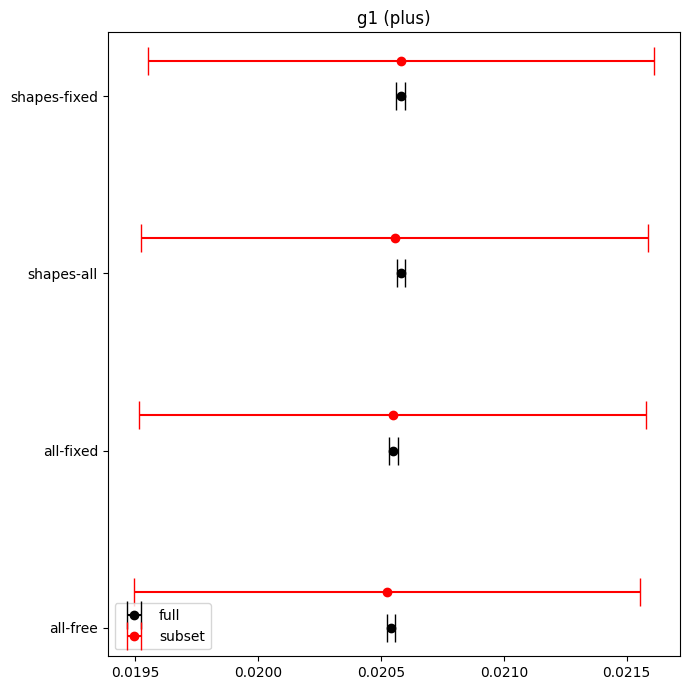

In [23]:

fig, ax = plt.subplots(1,1, figsize=(7,7))
ys = np.array([0.75, 0.5, 0.25, 0.0])

# multiplicative bias
ax.errorbar(x=mu1, y=ys, xerr=[s*3 for s in sigma1], color="k", fmt="o", capsize=10.0, label='full')
ax.errorbar(x=mu2,xerr=[s*3 for s in sigma2],  y=ys+0.05, color="r", fmt="o", capsize=10.0, label='subset')
# ax.errorbar(x=mu3, y=ys+0.1, color="b", fmt="o", capsize=10.0, label='gaussian')
# ax.errorbar(x=mu4, y=ys-0.05, color="m", fmt="o", capsize=10.0)


ax.set_yticks([0.75, 0.5, 0.25, 0.0])
ax.set_yticklabels(["shapes-fixed", "shapes-all", "all-fixed", "all-free"])
plt.title("g1 (plus)")
# ax.set_ylim(-0.1, 0.85)



# ax.set_xlim(-3, 3)
plt.legend()
plt.tight_layout()

In [27]:
(np.array(mu1) - np.array(mu3)) / 0.02

array([-1.33653013e-03, -7.02745840e-05, -2.39080990e-03,  9.37582693e-04])

## Error estimation

In [47]:
from bpd.utils import combine_subposts_gaussian
from tqdm import tqdm
errs1 = []
n_boots = 1000
for fp in errs_fpaths:
    ds = load_dataset(fp)
    g1p = ds['plus']['g1']
    g2p = ds['plus']['g2']
    g1m = ds['minus']['g1']
    g2m = ds['minus']['g2']
    gp = np.stack([g1p, g2p], axis=-1)
    gm = np.stack([g1m, g2m], axis=-1)
    assert gp.shape == (500, 1000, 2)
    ms = [] 
    for ii in tqdm(range(n_boots)):
        boot = np.random.randint(0, 500, (500,))
        _gp = gp[boot]
        _gm = gm[boot]
        mu_p, _ = combine_subposts_gaussian(_gp)
        mu_m, _ = combine_subposts_gaussian(_gm)
        gp1_mean = mu_p[0].item()
        gm1_mean = mu_m[0].item()
        m = (gp1_mean - gm1_mean) / 2/ 0.02 - 1
        ms.append(m)
    errs1.append(np.array(ms).std())

100%|██████████| 1000/1000 [01:18<00:00, 12.76it/s]


In [48]:
np.array(errs1) * 3 / 1e-3 

array([1.46810642, 1.84595328, 1.31886041, 2.62889204])

In [49]:
from bpd.utils import combine_subposts_gaussian
from tqdm import tqdm
errs2 = []
for fp in errs_fpaths:
    ds = load_dataset(fp)
    g1p = ds['plus']['g1']
    g2p = ds['plus']['g2']
    g1m = ds['minus']['g1']
    g2m = ds['minus']['g2']
    gp = np.stack([g1p, g2p], axis=-1)
    gm = np.stack([g1m, g2m], axis=-1)
    assert gp.shape == (500, 1000, 2)
    ms = (gp[:, :, 0].mean(1) - gm[:, :, 0].mean(1)) / 0.02 / 2 - 1
    errs2.append(ms.std() / np.sqrt(500))

In [50]:
np.array(errs2)  * 3 / 1e-3

array([0.75781401, 0.94637404, 0.77809427, 1.33108432])

# 10k example

In [5]:
fpath1= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_boots_111.npz"
fpath2= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_111_errs.npz"


In [10]:
# boot
ds1 = load_dataset(fpath1)
gpb = ds1['gp']
gpm = ds1['gm']

mb = (gpb[:, :, 0].mean(1) - gpm[:, :, 0].mean(1)) / 2/ 0.02 - 1
mb.std() * 3 / 1e-3

np.float64(4.55019546670417)

In [13]:
# subsets
ds2 = load_dataset(fpath2)
gps = ds2['g_plus']
gms = ds2['g_minus']
ms = (gps[:, :, 0].mean(1) - gms[:, :, 0].mean(1)) / 2/ 0.02 - 1
ms.std() / np.sqrt(500) * 3 / 1e-3

np.float64(4.515078143071639)

In [18]:
# subposterior combination
ds2 = load_dataset(fpath2)
gps = ds2['g_plus']
gms = ds2['g_minus']
n_boots = 1000
assert gps.shape == (500, 1000, 2)
ms = []
for ii in tqdm(range(n_boots)):
    boot = np.random.randint(0, 500, (500,))
    _gp = gps[boot]
    _gm = gms[boot]
    mu_p, _ = combine_subposts_gaussian(_gp)
    mu_m, _ = combine_subposts_gaussian(_gm)
    gp1_mean = mu_p[0].item()
    gm1_mean = mu_m[0].item()
    m = (gp1_mean - gm1_mean) / 2/ 0.02 - 1
    ms.append(m)
np.array(ms).std()  * 3 / 1e-3

100%|██████████| 1000/1000 [01:17<00:00, 12.87it/s]


np.float64(9.258945920442223)

# Multiplicative bias 

In [5]:
fpath1p= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_512_plus.npz"
fpath1m= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_512_minus.npz"
fpath2p= "/pscratch/sd/i/imendoza/data/cache_chains/exp71_51/shear_samples_512_plus.npz"
fpath2m= "/pscratch/sd/i/imendoza/data/cache_chains/exp71_51/shear_samples_512_minus.npz"
fpath3p= "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/g_samples_512_plus.npz"
fpath3m= "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/g_samples_512_minus.npz"
fpath4p= "/pscratch/sd/i/imendoza/data/cache_chains/exp73_51/shear_samples_512_plus.npz"
fpath4m= "/pscratch/sd/i/imendoza/data/cache_chains/exp73_51/shear_samples_512_minus.npz"

fpaths = [(fpath1p, fpath1m), (fpath2p, fpath2m), (fpath3p, fpath3m), (fpath4p, fpath4m)]

In [6]:
efpath1= "/pscratch/sd/i/imendoza/data/cache_chains/exp70_51/g_samples_514_errs.npz"
efpath2= "/pscratch/sd/i/imendoza/data/cache_chains/exp71_51/g_samples_514_errs.npz"
efpath3= "/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/g_samples_514_errs.npz"
efpath4= "/pscratch/sd/i/imendoza/data/cache_chains/exp73_51/g_samples_514_errs.npz"

errs_fpaths = [efpath1, efpath2, efpath3, efpath4]

In [10]:
# full posterior 
m_full = []
for (fpp, fpm) in fpaths:
    dsp = load_dataset(fpp)
    dsm = load_dataset(fpm)
    g1p = dsp['samples']['g1']
    g1m = dsm['samples']['g1']
    assert g1p.ndim == 1
    m = (g1p.mean() - g1m.mean()) / 2/ 0.02 - 1
    m_full.append(m)
m_full = np.array(m_full)

In [11]:
# full posterior 
m_sub = []
sigma_m = [] 
for fp in errs_fpaths:
    ds = load_dataset(fp)
    g1p = ds['plus']['g1']
    g1m = ds['minus']['g1']
    assert g1p.ndim == 2
    ms = (g1p.mean(1) - g1m.mean(1)) / 2/ 0.02 - 1
    m_mean = ms.mean()
    sig = ms.std() / np.sqrt(len(ms))
    m_sub.append(m)
    sigma_m.append(sig)
m_sub = np.array(m_sub)
sigma_m = np.array(sigma_m)

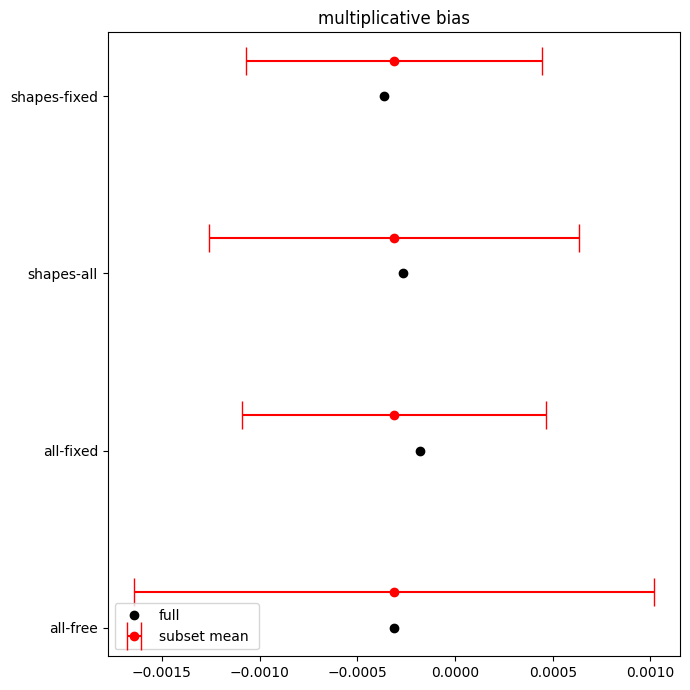

In [15]:

fig, ax = plt.subplots(1,1, figsize=(7,7))
ys = np.array([0.75, 0.5, 0.25, 0.0])

# multiplicative bias
ax.errorbar(x=m_full, y=ys, color="k", fmt="o", capsize=10.0, label='full')
ax.errorbar(x=m_sub, xerr=[s*3 for s in sigma_m],  y=ys+0.05, color="r", fmt="o", capsize=10.0, label='subset mean ')
# ax.errorbar(x=mu3, y=ys+0.1, color="b", fmt="o", capsize=10.0, label='gaussian')
# ax.errorbar(x=mu4, y=ys-0.05, color="m", fmt="o", capsize=10.0)


ax.set_yticks([0.75, 0.5, 0.25, 0.0])
ax.set_yticklabels(["shapes-fixed", "shapes-all", "all-fixed", "all-free"])
plt.title("multiplicative bias")
# ax.set_ylim(-0.1, 0.85)



# ax.set_xlim(-3, 3)
plt.legend()
plt.tight_layout()